<a href="https://colab.research.google.com/github/machine-perception-robotics-group/MPRGDeepLearningLectureNotebook/blob/master/12_gan/01_Variational_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational autoencoder (VAE)
## 目的
Pytorchを用いてVariational autoencoder (VAE)を構築し，学習する．<br>
また，VAEの中間層で得られる特徴マップをUniform Maniforld Approximation and Projection (UMAP)を用いて2次元まで次元を削減して分布を確認する．

## 画像分類と画像生成
機械学習をはじめとした画像分類モデルは，任意のデータ$x$をモデルに与えるとクラス確率を返すネットワークです．画像分類は任意のデータセットを用いて経験損失を最小化するようなモデルの重みパラメータを発見することが大きな目的です．\
一方，データ（画像や音声等）生成をするニューラルネットワークは，任意の潜在変数や過去の系列情報からデータ$p_{\theta}(x|z)$を生成することを目的としています．ただ，闇雲に潜在変数を与えているだけでは，求めたデータの生成が困難です．\
そのため，潜在変数から画像を生成するVAEでは，真のデータ分布$p(x)$を仮定した潜在空間から変数をサンプリングする戦略立てがされています．

## VAEの理論（なぜ変分推論？）
先に述べたように，VAEでは画像生成をするために真のデータ分布$p(x)$を利用する必要があります．しかしながら，我々がよく目にするデータセット達の分布は，複雑なので物理的に求めることが不可能です．\
では，ある潜在変数からデータを生成する$p_{\theta}(x|z)$を逆向きに$p_{\theta}(z|x)$として利用することで，実データの分布を探れそうですが，ニューラルネットワークの逆変換になるため計算が困難です．\
そこで，VAEでは実データの次元数を圧縮する$q_{\phi}(z|x)$を利用します．これによって，ニューラルネットワークを逆向きに利用する必要がなくなり計算が可能です．

### 変分下限
Encoder$q_{\phi}(z|x)$とDeocder$p_{\theta}(x|z)$を含むモデルを単に$p(x)$として，最尤推定により$x$にフィットするような最適なパラメータを発見することを考えます．\
しかしながら，積分の最大化問題を扱う必要があり，少々扱いづらいので変分下限を最大化することで下から抑えます．\
変分下限は以下の式変形によって得られます．
\begin{eqnarray}
\log p(x) &=& \log\int p(x,z)dz\\
&=& \log\int q(z|x)\frac{p(x, z)}{q(z|x)}\\
&\geq& \int q(z|x)\log\frac{p(x, z)}{q(z|x)}\\
&=& \mathcal{L}(x,z)
\end{eqnarray}
上の式変形の最後に出てきた$\mathcal{L}(x,z)$が変分下限となり，これを最大化すれば良いことになります．\
しかしながら，連続値に不等号が絡んでいるので厳密な最適値を導き出すことが困難で，僅かながらもギャップが生まれてしまいます．
従って，$p(x) - \mathcal{L}(x,z)$によってギャップを効率的に埋める術を知る必要があります．

### 変分下限のギャップ
$p(x) - \mathcal{L}(x,z)$のままでは先に進まないので，以下に式変形を示します．
\begin{eqnarray}
\log p(x) - \mathcal{L}(x,z) &=& \log p(x) - \int q(z|x)\log\frac{p(x,z)}{q(z|x)}dz\\
&=& \log p(x)\int q(z|x)dz - \int q(z|x)\log\frac{p(x,z)}{q(z|x)}dz\\
&=& \int q(z|x)\log p(x) dz - \int q(z|x)\log\frac{p(z|x)p(x)}{q(z|x)}dz\\
&=& \int q(z|x)\log p(x) dz - \int q(z|x)\left(\log p(z|x) + \log p(x) - \log q(z|x)\right)dz\\
&=& \int q(z|x)\left(\log p(x) - \log p(z|x) - \log p(x) \log q(z|x)\right)dz\\
&=& \int q(z|x)\log \frac{q(z|x)}{p(z|x)} dz\\ 
&=& D_{KL}[q(z|x)\|p(z|x)]
\end{eqnarray}
式変形の結果から，変分下限の素性が$\mathcal{L}(x,z)=\log p(x) - D_{KL}[q(z|x)\|p(z|x)]$だとわかりました．\
$\log p(x)$はされるため，非負のKLダイバージェンスを最小化すれば，変分下限を最大化することと同値です．

EncoderとDecoderそれぞれが出力する分布を近似すれば，真の分布を知ることができそうですが，Decoderを向きに利用している$p(z|x)$が含まれているので，計算が困難です．$D_{KL}[q(z|x)\|p(z|x)]$は綺麗な形にまとめれそうなので式変形をします．

### $D_{KL}[q(z|x)\|p(z|x)]$の式変形
ニューラルネットワークの逆変換が含まれている$D_{KL}[q(z|x)\|p(z|x)]$を式変形して美しい形にします．
\begin{eqnarray}
D_{KL}[q(z|x)\|p(z|x)] &=& \int q(z|x)\log\frac{q(z|x)}{p(z|x)}dz
\end{eqnarray}
ニューラルネットワークの逆変換である$p(z|x)$をなくすためにベイズの定理$p(z|x) = \frac{p(x|z)p(z)}{p(x)}$を利用して式変形を進めます．
\begin{eqnarray}
\int q(z|x)\log\frac{q(z|x)}{p(z|x)}dz &=& \int q(z|x)\left(\log q(z|x) - \log \frac{p(x|z)p(z)}{p(x)}\right)dz\\
&=& \int q(z|x)\left(\log q(z|x) - \log p(x|z) - \log p(z) + \log p(x) \right)dz\\
&=& \int q(z|x)\left(\log q(z|x) - \log p(x|z) - \log p(z)\right)dz + \log p(x)\\
&=& \int q(z|x)\left(\log \frac{q(z|x)}{p(z)}-\log p(x|z)\right)dz + \log p(x)\\
&=& \int q(z|x)\log \frac{q(z|x)}{p(z)}dz - \int q(z|x)\log p(x|z)dz + \log p(x)\\
&=& D_{KL}[q(z|x)\|p(z)] - \mathbb{E}_{q(z|x)}[\log p(x|z)] + \log p(x)
\end{eqnarray}
美しい形になったので，式変形をした結果を変分下限の式$\mathcal{L}(x,z)=\log p(x) - D_{KL}[q(z|x)\|p(z|x)]$に代入すると以下のように表すことができます．
\begin{eqnarray}
\mathcal{L}(x,z) &=& \log p(x) - D_{KL}[q(z|x)\|p(z)] + \mathbb{E}_{q(z|x)}[\log p(x|z)] - \log p(x)\\
&=& \mathbb{E}_{q(z|x)}[\log p(x|z)] - D_{KL}[q(z|x)\|p(z)]
\end{eqnarray}

これまでの式変形を踏まえると，変分下限はEncdoerに関するDecoderの期待値，つまり生成した画像と真のデータのエントロピーと，Encoderの出力する事後確率$q(z|x)$とユーザが任意に設定する事前確率$p(z)$を計算すれば良いことになります．
ここで，事前確率には確率分布の中でも比較的扱いが容易な標準正規分布が利用されることが多いです．

## モジュールのインポート
VAEを構築する際に必要となるモジュールをインポートします．

In [12]:
import os
import zipfile
import urllib.request
import numpy as np
from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

## ネットワークの構築
次にVAEのネットワークを構築します．はじめに述べたように，VAEは画像データを入力して特徴を抽出する**Encoder**と，任意のサイズのベクトルを入力して画像データを復元する**Decoder**で構築されています．<br>
Decoderへ入力する潜在変数は，通常のautoencoderであればEncoderからの出力値を利用します．
一方で，VAEではEncodeした特徴量が任意の確率分布に従うように学習をします．
最も愚直な方法だとEncoderで抽出した特徴量を正規分布の平均$\mu$及び分散$\sigma$として扱うことで，Encoderの出力が正規分布に従うと考えられます．
Encoder，Decoderを個別に学習するのであれば，この方法でも問題ないです．
しかしながら，VAEはEncoderとDecoderを一貫して学習するため，このままだと中間層での微分が不可能です．
この問題点は，ニューラルネットワークを学習する際には非常に深刻な問題になります．
なぜなら，ニューラルネットワークは計算した誤差を逆伝播してネットワークのパラメータの更新量を決定することが必要不可欠であるため，ネットワーク全体を通して計算グラフがつながっている必要があるからです．<br>
そこで，EncoderとDecoderの間にReparameterization trickと呼ばれる処理を用いることで解決します．これは，Encoderが出力する特徴マップが正規分布に従うように学習するテクニックです．\
Reparameterization trickでは以下に示す式によって潜在変数$\bf{v}\in \mathbb{R}^{N}$をサンプリングします．
$$
\mathbf{v} = \mu + \exp\left(\frac{1}{2}\log\sigma\right)\odot\epsilon
$$
$$
s.t. \epsilon\leftarrow N(0, 1)
$$

VAEの全体像のイメージを以下の図に示します．
Encoder及びDecoderは，全結合層とReLUを用いて構築します．平均$\mu$，分散$\sigma$はそれぞれ別の全結合層によって獲得します．ここで注意すべき点は，$\sigma$がReparametarization trickの計算過程で対数をとるため，$\sigma>0$でないと計算不可になることです．これを解決するために，厳密には全結合層が出力したベクトルを$\log\sigma$であると仮定して計算をしています．

<img src="https://dl.dropboxusercontent.com/s/efatumuniv5zdeq/vae.png" width=50%>

In [13]:
class VAE(nn.Module):
    def __init__(self, latent_dim=10):
        super(VAE, self).__init__()
        self.encoder = self.make_encoder(in_dim=784)
        self.l_mu = nn.Linear(100, latent_dim)
        self.l_var = nn.Linear(100, latent_dim)
        self.decoder = self.make_decoder(in_dim=latent_dim, out_dim=784)
        
    def make_encoder(self, in_dim=784):
        encoder = nn.Sequential(
            nn.Linear(in_dim, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 100),
            nn.ReLU(inplace=True))
        return encoder
    
    def make_decoder(self, in_dim=10, out_dim=784):
        decoder = nn.Sequential(
            nn.Linear(in_dim, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, out_dim))
        return decoder
    
    def reparameterization_trick(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.randn_like(std)
        latent = eps.mul(std).add_(mu)
        return latent
    
    def forward(self, x, plot=False):
        h = self.encoder(x)
        mu = self.l_mu(h)
        logvar = self.l_var(h)
        latent = self.reparameterization_trick(mu, logvar)
        out = self.decoder(latent)
        if plot:
            return out, mu, logvar, latent
        else:
            return out, mu, logvar

## データセット，最適化関数などの設定
データセットはMNISTを用いて学習をします．
最適化関数にはAdam Optimizerを使用します．

In [14]:
class MNIST_Loader(Dataset):
  def __init__(self, train=True, download=True, transform=None):
    self.transform = transform
    self.url = 'https://www.dropbox.com/s/hc7ukm7vzst5e40/MNIST.zip?dl=1'
    
    if download:
      self._download()
    
    dname = os.path.join(self.url.rpartition('/')[2][:-9], 'processed')
    if train:
      datapath = os.path.join(dname, 'training.pt')
    else:
      datapath = os.path.join(dname, 'test.pt')
  
    self.data = torch.load(datapath)

  def __len__(self):
    return len(self.data[0])

  def _download(self):
    filename = self.url.rpartition('/')[2][:-5]
    urllib.request.urlretrieve(self.url, filename)

    with zipfile.ZipFile(filename) as existing_zip:
      existing_zip.extractall()
    os.remove(filename)

  def __getitem__(self, i):
    image = transforms.ToPILImage()(self.data[0][i])
    label = self.data[1][i]

    if self.transform:
      image = self.transform(image)
    return image, label

In [15]:
transform_train = transforms.Compose([transforms.ToTensor()])
try:
  mnist_data = datasets.MNIST(root='./data', train=True, transform=transform_train, download=True)
except:
  print('Warning: Switch the original implementation because official MNIST data did not download (probably the official server has down).')
  mnist_data = MNIST_Loader(train=True, download=True, transform=transform_train)
print('Done!')

training_data = DataLoader(dataset=mnist_data,
                           batch_size=100,
                           shuffle=True,
                           drop_last=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = VAE(latent_dim=100).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

Done!


## 誤差関数の設定
VAEの誤差関数を定義します．\
はじめに説明したVAEの理論的なお話で求めた以下の式
\begin{eqnarray}
\mathcal{L}(x,z) &=& \mathbb{E}_{q(z|x)}[\log p(x|z)] - D_{KL}[q(z|x)\|p(z)]
\end{eqnarray}
を誤差関数とします．
一般に，第1項は再構成誤差 (Reconstruction error)，第2項は正則化項 (Regularization  error)と呼ばれます．\
VAEの論文で再構成誤差は，負の対数尤度をとったベルヌーイ分布を仮定していますが，ここではBinary cross entropy (BCE)とKLダイバージェンスで定義します．<br>
BCE lossは，Nをデータ数，xをネットワークの出力（ここでは出力画像），yを教師信号（ここでは入力画像）とすると，以下の式で表されます．
$$
\mathcal{L}_{bce} = -\sum_{i=1}^{N}y_{i}\log(x_{i}) + (1-y_{i})\log(1-x_{i})\\
$$
負の対数をとったベルヌーイ分布を展開すると，最終的にはBCEと同じになるので，興味があるひとは手を動かしてみるといいと思います．<br>
また，潜在変数を標準正規分布へ近似するためのKLダイバージェンス$D_{KL}\left[N(\mu, \sigma)\|N(0, 1)\right]$は，以下の式で表現されます．（詳細な展開は省きました．）
$$
D_{KL}\left[N(\mu, \sigma)\|N(0, 1)\right] = \frac{1}{2}\sum_{i}(1+2\log \sigma_{i}-\mu_{i}^{2} - \sigma_{i}^{2})
$$
KLダイバージェンスは，ネットワーク全体の正則化の役割を果たします．

※ KLダイバージェンスは，分布間の距離を図る指標ですが，厳密な距離を表現していないことに注意してください．また，双方向性がないことにも注意してください．

In [16]:
def loss_function(tilde_x, x, mu, log_var, bce):
    reconstruction_loss= bce(tilde_x.view(-1, 784), x.view(-1, 784))
    kld = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return reconstruction_loss + kld

## ネットワークの学習
BCE lossを計算するためには，用いる値が[0, 1]の間で収まっている必要があります．しかし，便宜上Decoderの出力値にSigmoid関数を含めませんでした．そのため，**BCEWithLogitsLoss**という関数を用いることで解決します．

※ KLダイバージェンスが同時確率であるため，VAEの再構成誤差に対応するBCE lossは全体を平均しない代わりに，要素全てを合計します．そのため，学習に使用する画像データの解像度と比例して誤差が増加することを覚えておいてください．誤差が大きいからと言って誤差を平均すると，KLダイバージェンスが負の値をとったり，画像の復元ができなくなるので注意してください．

学習回数は，n_epochの数を変化させることで変更が可能です．
MNIST程度の画像であれば，10epoch学習するだけでも十分です．

In [17]:
n_epoch = 10
bce = nn.BCEWithLogitsLoss(reduction='sum')

for epoch in range(1, n_epoch+1):
    for idx, (x, _) in enumerate(training_data):
        x = x.cuda()
        optimizer.zero_grad()
        tilde_x, mu, log_var = model(x.view(x.size(0), -1))
        total_loss = loss_function(tilde_x, x, mu, log_var, bce)
        total_loss.backward()
        optimizer.step()
        
        if idx % 100 == 0:
            print('Training epoch: {} [{}/{} ({:.0f}%)] | Total loss: {:.6f} |'\
                  .format(epoch, idx * len(x), len(training_data.dataset),
                  100. * idx / len(training_data), total_loss.item()))

Training epoch: 1 [0/60000 (0%)] | Total loss: 54584.636719 |
Training epoch: 1 [10000/60000 (17%)] | Total loss: 20568.640625 |
Training epoch: 1 [20000/60000 (33%)] | Total loss: 19161.417969 |
Training epoch: 1 [30000/60000 (50%)] | Total loss: 17487.498047 |
Training epoch: 1 [40000/60000 (67%)] | Total loss: 17380.775391 |
Training epoch: 1 [50000/60000 (83%)] | Total loss: 16298.337891 |
Training epoch: 2 [0/60000 (0%)] | Total loss: 16158.537109 |
Training epoch: 2 [10000/60000 (17%)] | Total loss: 15685.832031 |
Training epoch: 2 [20000/60000 (33%)] | Total loss: 15410.413086 |
Training epoch: 2 [30000/60000 (50%)] | Total loss: 14735.932617 |
Training epoch: 2 [40000/60000 (67%)] | Total loss: 14528.487305 |
Training epoch: 2 [50000/60000 (83%)] | Total loss: 14498.449219 |
Training epoch: 3 [0/60000 (0%)] | Total loss: 13838.949219 |
Training epoch: 3 [10000/60000 (17%)] | Total loss: 13351.801758 |
Training epoch: 3 [20000/60000 (33%)] | Total loss: 12822.134766 |
Training e

## 学習済みモデルを用いて画像の復元
先ほど学習した重みパラメータを用いて，画像の復元をします．
まず，mnistのテストデータからランダムにサンプルした画像を入力した結果を確認します．

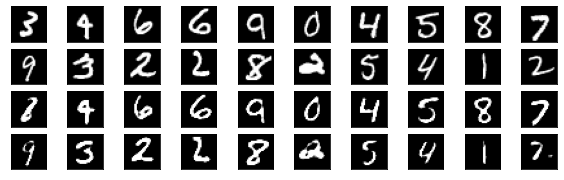

In [ ]:
test_transform = transforms.Compose([transforms.ToTensor()])
mnist_testdata = datasets.MNIST(root='./data', train=False, transform=test_transform)
test_data =DataLoader(dataset=mnist_testdata, batch_size=20, shuffle=True)
for idx, (x, y) in enumerate(test_data):
    if idx > 0:break
    x_in = x.cuda()
    y_in = y
    ims, mu, logvar, latent = model(x_in.view(x_in.size(0), -1), plot=True)

output_img = (ims*256.).clamp(min=0., max=255.).view(-1, 1, 28, 28).data.cpu().squeeze().numpy().astype(np.uint8)
input_img = (x_in * 256.).clamp(min=0., max=255.).data.cpu().squeeze().numpy()
latent = latent.data.cpu().numpy()

fig = plt.figure(figsize=(10, 3))
# MNISTのテストデータ (上)
for i, im in enumerate(input_img):
    ax = fig.add_subplot(4, 10, i+1, xticks=[], yticks=[])
    ax.imshow(im, 'gray')

# VAEから出力された画像データ　（下）
for i, im in enumerate(output_img):
    ax = fig.add_subplot(4, 10, i+21, xticks=[], yticks=[])
    ax.imshow(im, 'gray')

## UMAPを用いた次元削減
ここでは，Encoderの中間層を可視化するために，UMAPによって次元削減をしてmatplotlibによって散布図を描画します．<br>
UMAPを使用するにあたって，まずumap-learnと呼ばれるモジュールをインストールする必要があるので，以下のコマンドを実行します．

In [ ]:
!pip install umap-learn

## 特徴マップの次元削減及びデータのプロット
次元削減するためのモジュールとして先ほどインストールしたumapをインポートします．
他のモジュールは，グラフに画像を貼り付けるために必要な物や3次元プロットする際に必要なモジュールです．今回は，2次元のみを紹介するので一番下の一行はなくても動作します．

In [ ]:
import umap
import matplotlib.cm as cm
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from mpl_toolkits.mplot3d import Axes3D

## Umapを使用するためのクラスの構築
ここで定義するクラスを使用することで，umapによって次元を削減することができます．
注意すべきことは，umapの関数へ与えるnumpy配列を1次元にしておくことです．
1次元にした配列をプロットしたいサンプル数分だけ積み上げてumapの関数に与えることで圧縮してくれます．<br>
umapの関数のn_componentsという引数は，圧縮する次元数を表しているので，3次元のプロットをしたいときはn_components=3と変更してください．

In [ ]:
class Compress:
    def __init__(self, seed=-1):
        self.data = []
        self.target_data = None
        self.target_label = None
        self.compress_data = None
        self.out_data = None
        self.seed = seed

    # 1クラス分のデータを入力する (何回も呼び出し可能)
    def stack_data(self, data, cls_id):
        d = np.hstack((np.ravel(data), cls_id))
        self.data.append(d.tolist())

    # データを整列した後，次元圧縮
    def fitting(self, data=None, n_components=2, n_neighbors=15, min_dist=0.1):
        if data is not None:
            self.data = data
        # 2次元リストからnumpy配列へ変換
        self.data = np.asarray(self.data, dtype=np.float32)
        # 入力データとラベルに分割
        self.target_data = self.data[:, 0:-1]
        self.target_label = np.reshape(self.data[:, -1], newshape=(-1, 1))

        # 次元圧縮の実行
        self.compress_data = umap.UMAP(n_neighbors, n_components, min_dist=min_dist).fit_transform(self.target_data)

        # 圧縮データにラベルを付与
        self.out_data = np.hstack((self.compress_data, self.target_label))
        return self.out_data

## データをプロットするための準備
このクラスは，2次元平面のグラフに散布図としてデータをプロットする関数と，対応する座標の位置にVAEによって復元した画像を貼り付ける2つの方法を含んでいます．<br>
画像を貼り付けるときは，貼り付ける画像よりひとまわり大きい画像をbackgroundとすることでフレームの役割を担っています．
フレームは，クラスごとに色付けしています．<br>
プロットした結果は，current directoryに保存されます．

In [ ]:
class Visualize:
    def __init__(self, color_map, fig_size=(10, 6), dpi=512, color_num=10):
        self.fig_size = fig_size
        self.dpi = dpi

        self.color_map = color_map
        self.frame_width = 5
        self.resize = None

    # 画像をグラフに出力する
    def draw_image2d(self, save_name, coords, imgs, resize=(28, 28), zoom=1, frame_width=1):
        plt.figure()
        fig, ax = plt.subplots(figsize=self.fig_size, dpi=self.dpi)

        self.resize = resize
        x_vec, y_vec = [], []
        for coord, _img in zip(coords, imgs):
            _x, _y = coord[0], coord[1]
            image = self.create_image(_img, coord[2], frame_width)
            im = OffsetImage(image, zoom=zoom)
            ab = AnnotationBbox(im, (_x, _y), xycoords='data', frameon=False)
            ax.add_artist(ab)
            x_vec.append(_x)
            y_vec.append(_y)
        ax.plot(x_vec, y_vec, 'ko', alpha=0)
        plt.axis('off')
        fig.savefig(save_name, bbox_inches='tight', pad_inches=0)

    # 画像に image_label に対応した色の枠を付ける
    def create_image(self, img, img_label, frame_width):

        pil_img = Image.fromarray(img).convert('RGB').resize(self.resize)
        img_w, img_h = int(pil_img.size[0]), int(pil_img.size[1])

        bg_w = img_w + (frame_width * 2)
        bg_h = img_h + (frame_width * 2)
        bg = Image.new('RGB', (bg_w, bg_h), self.color_map[int(img_label)])

        left = (bg_w - img_w) // 2
        top = (bg_h - img_h) // 2
        bg.paste(pil_img, (left, top))
        return np.asarray(bg, dtype=np.uint8)

    def draw_point2d(self, save_name, coords):
        plt.figure()
        fig, ax = plt.subplots(figsize=self.fig_size, dpi=self.dpi)
        for coord in coords:
            ax.scatter(coord[0], coord[1], marker="${}$".format(coord[2]), c=self.color_map[int(coord[2])], linewidths=0.8)
        #ax.legend()
        ax.axis('off')
        fig.savefig(save_name, bbox_inches='tight', pad_inches=0)

UMAPなどの次元削減手法は，動作させるたびに異なる分布が形成されます．
これは，次元を圧縮するために類似した特徴量を近似する計算によるものだと考えられます．

Compressing data ...
Done!


<Figure size 432x288 with 0 Axes>

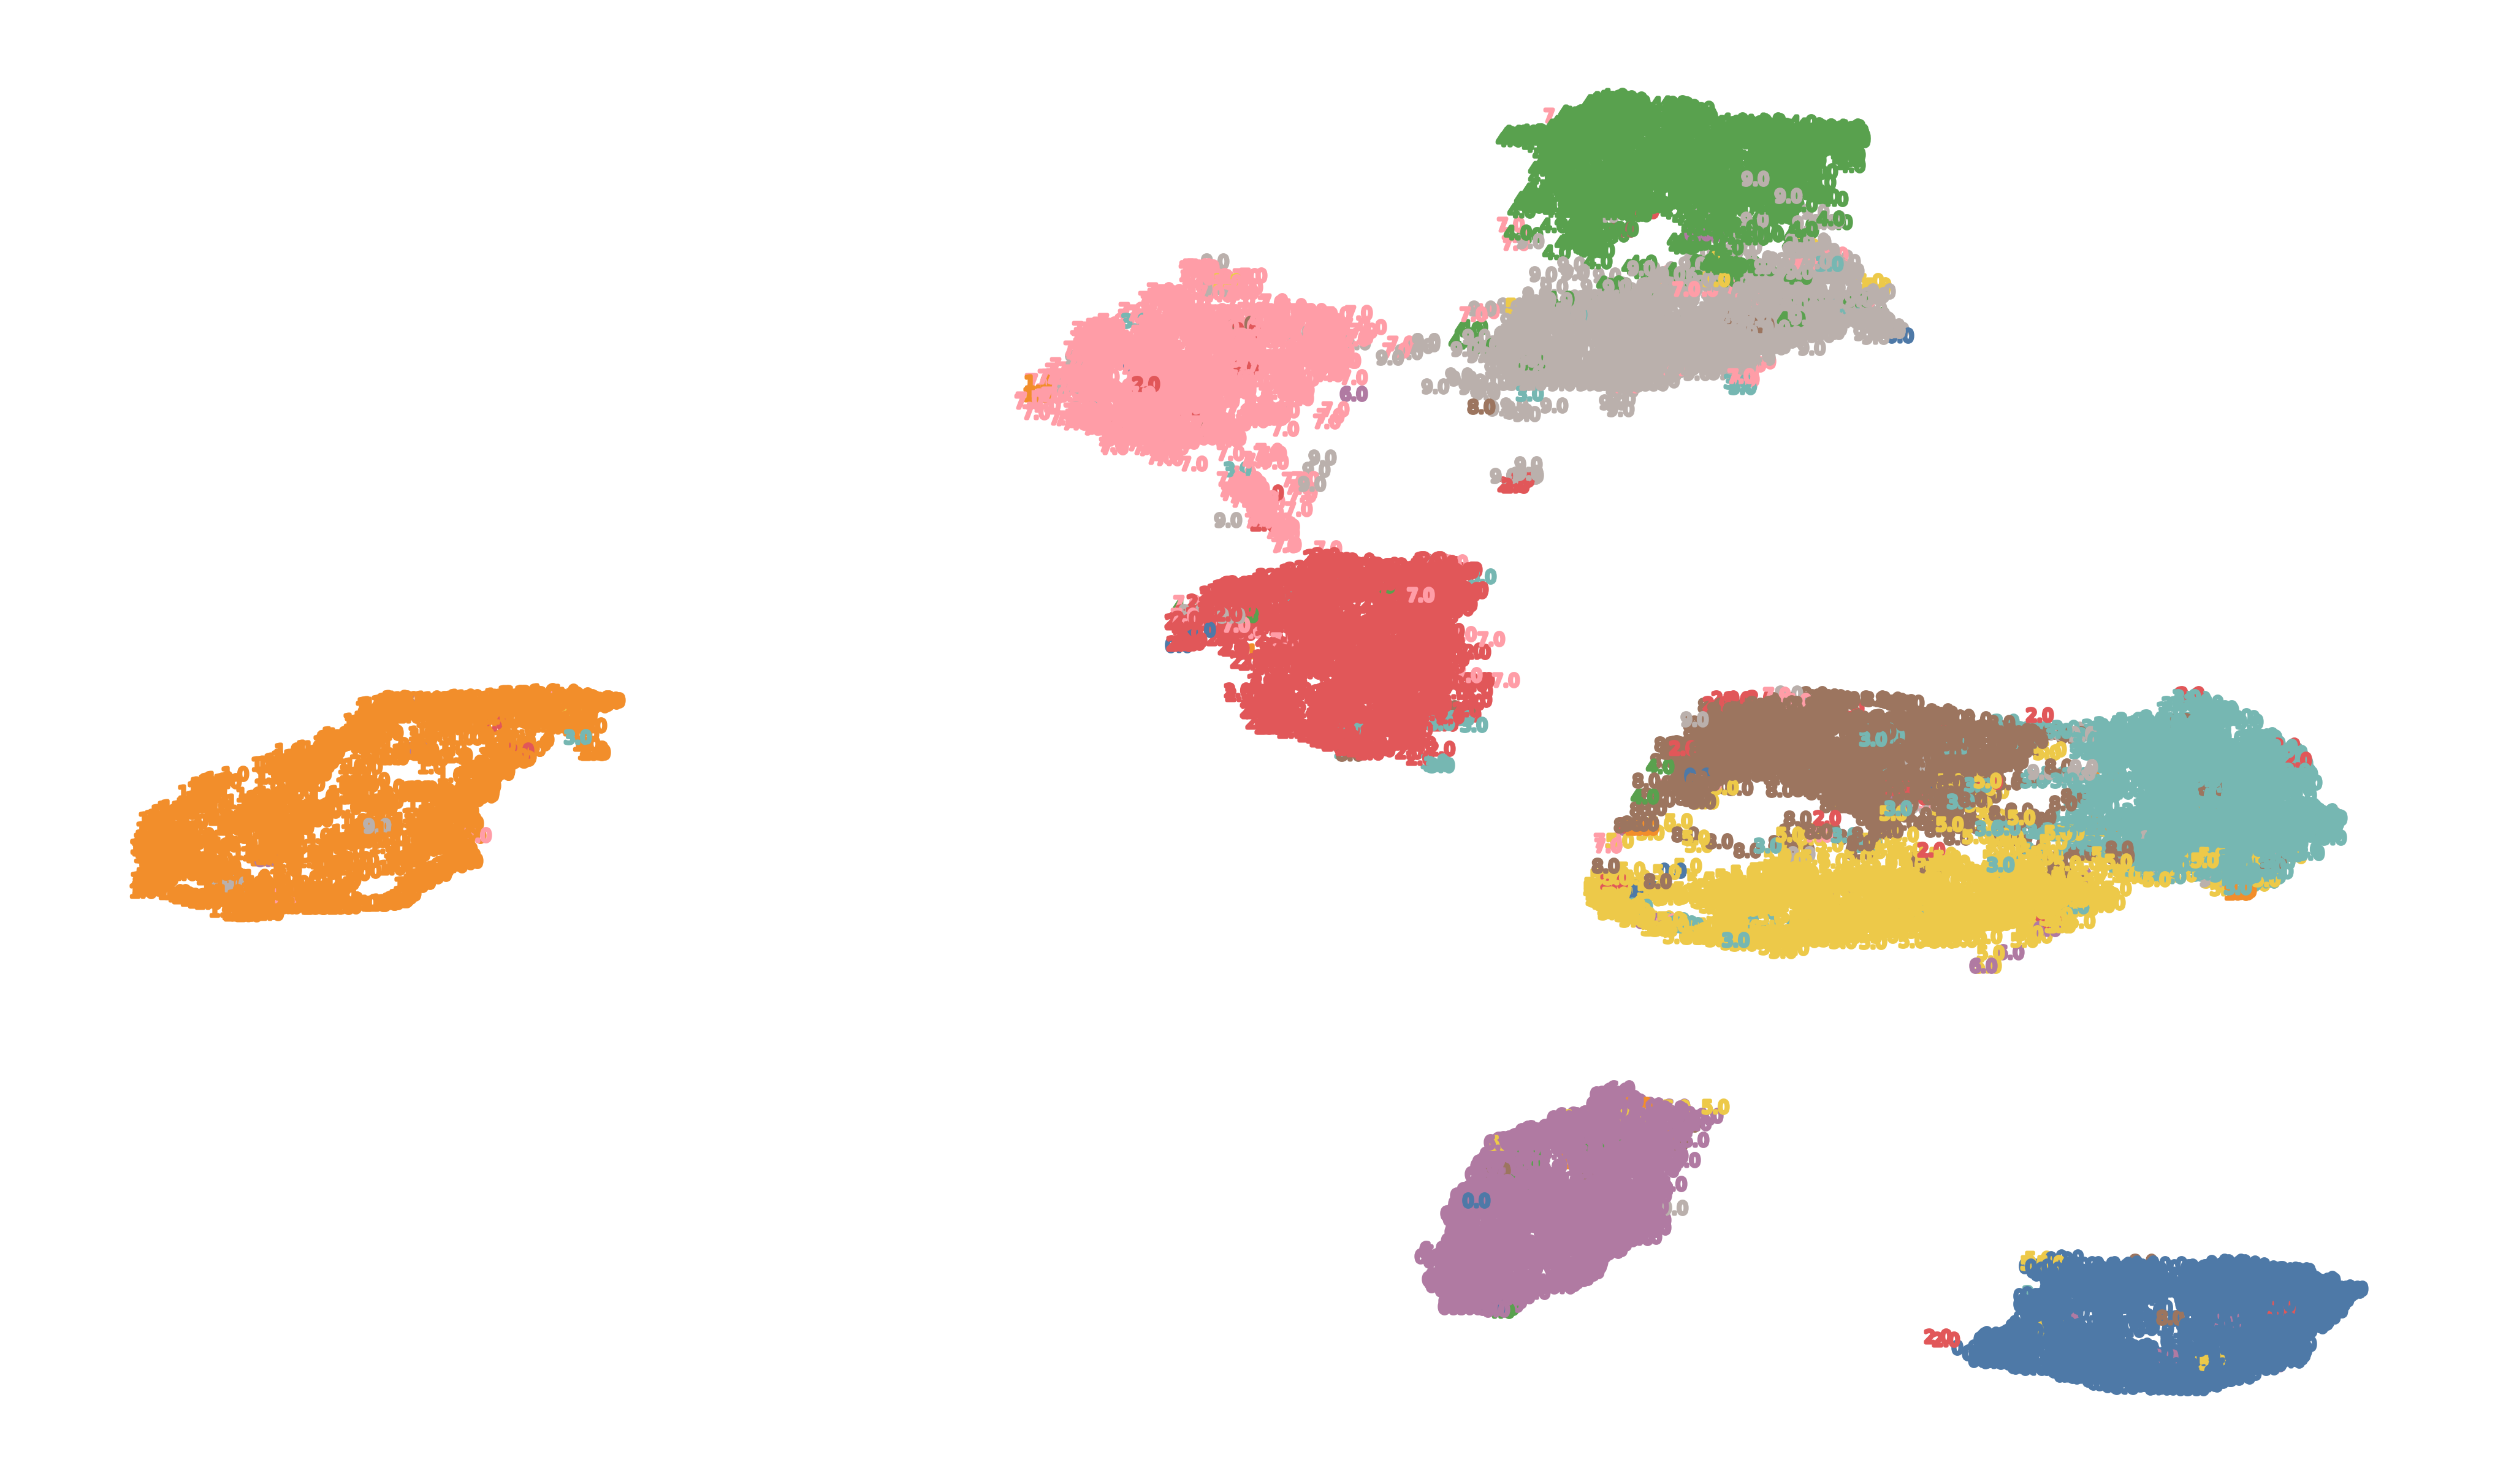

In [ ]:
compress = Compress()
test_transform = transforms.Compose([transforms.ToTensor()])
mnist_testdata = datasets.MNIST(root='./data', train=False, transform=test_transform)
test_data =DataLoader(dataset=mnist_testdata, batch_size=100, shuffle=True)
for idx, (x, y) in enumerate(test_data):
    x_in = x.cuda()
    y_in = y
    ims, mu, logvar, latent = model(x_in.view(x_in.size(0), -1), plot=True)
    _y_in = np.expand_dims(y_in, axis=1)
    _mu = mu.data.cpu().numpy()
    if idx > 0:
        data = np.concatenate((data, np.concatenate((_mu, _y_in), axis=1)), axis=0)
    else:
        data = np.concatenate((_mu, _y_in), axis=1)

print('Compressing data ...')
out = compress.fitting(data, n_components=2, n_neighbors=10, min_dist=0.1)
print('Done!')

cycle_color = ['#4E79A7', '#F28E2B', '#E15759','#76B7B2','#59A14E', '#EDC949','#B07AA2','#FF9DA7','#9C755F','#BAB0AC']
visualize = Visualize(color_map=cycle_color)
visualize.draw_point2d('umap_result.jpg', out)

# 課題
1. 正規分布から適当にサンプリングしてきたベクトルで画像生成してみましょう
2. VAEの中間層のユニット数を変更して学習した際にどのような傾向が現れるか確認してみましょう．


# 参考文献
[1] Diederik P. Kingma and Max Welling, Auto-Encoding Variational Bayes, ICLR, 2014.\
[2] Leland McInnes, John Healy and James Melville, Umap: Uniform manifold approximation and projection for dimension reduction, arXiv, 2018.